SIMPLEST possible application case: don't do any fine-tuning of existing model weights; just learn a frame-level decoder. Can we do it?

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
from pathlib import Path

import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import torch
import transformers
from transformers import AutoConfig
from transformers import Wav2Vec2Model
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from models.frame_level import FrameLevelRNNClassifier
from models.transformer import DataCollator

In [5]:
model_dir = "out/rnn/rnn2_hidden128_drop6/checkpoint-2200/"
device = "cuda:0"

In [6]:
model = FrameLevelRNNClassifier.from_pretrained(model_dir).to(device)

tokenizer = transformers.Wav2Vec2Tokenizer.from_pretrained("charsiu/tokenizer_en_cmu")
feature_extractor = transformers.Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
processor = transformers.Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Some weights of FrameLevelRNNClassifier were not initialized from the model checkpoint at out/rnn/rnn2_hidden128_drop6/checkpoint-2200/ and are newly initialized: ['wav2vec2.encoder.layers.6.attention.q_proj.bias', 'wav2vec2.encoder.layers.8.feed_forward.output_dense.bias', 'wav2vec2.encoder.layers.10.feed_forward.intermediate_dense.weight', 'wav2vec2.encoder.layers.6.feed_forward.intermediate_dense.weight', 'wav2vec2.encoder.layers.9.layer_norm.bias', 'wav2vec2.encoder.layers.7.attention.k_proj.weight', 'wav2vec2.encoder.layers.8.attention.q_proj.bias', 'wav2vec2.encoder.layers.7.attention.k_proj.bias', 'wav2vec2.encoder.layers.8.final_layer_norm.bias', 'wav2vec2.encoder.layers.11.feed_forward.output_dense.weight', 'wav2vec2.encoder.layers.7.feed_forward.output_dense.bias', 'wav2vec2.encoder.layers.11.attention.q_proj.weight', 'wav2vec2.encoder.layers.11.attention.q_proj.bias', 'wav2vec2.encoder.layers.9.attention.k_proj.weight', 'wav2vec2.encoder.layers.8.attention.out_proj.weight', 

In [7]:
corpus_path = "timit_phoneme_corpus"

corpus = datasets.load_from_disk(corpus_path)

In [8]:
def compute_metrics(p: transformers.EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    label_mask, labels = p.label_ids

    def evaluate_label(j):
        preds_j = preds[:, :, j]
        labels_j = labels[:, :, j]

        preds_j = preds_j[label_mask == 1]
        labels_j = labels_j[label_mask == 1]
        if labels_j.std() == 0:
            # Only one class. Quit
            return None
        return roc_auc_score(labels_j, preds_j)

    roc_auc_scores = [evaluate_label(j) for j in range(preds.shape[-1])]
    return {"roc_auc": np.mean([score for score in roc_auc_scores if score is not None])}

In [9]:
coll = DataCollator(processor=processor, model=model, padding=True,
                    num_labels=tokenizer.vocab_size)
training_args = TrainingArguments(
    do_train=False,
    do_eval=True,
    do_predict=True,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    use_cpu=device == "cpu",
    no_cuda=device == "cpu",
    output_dir=model_dir,
    resume_from_checkpoint=model_dir,
    label_names=["label_mask", "labels"],
)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=coll,
    compute_metrics=compute_metrics,
    train_dataset=corpus["train"],
    eval_dataset=corpus["test"],
    tokenizer=processor.feature_extractor,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Evaluate

In [10]:
# Determine optimal cut-off probability for each phone
from sklearn.metrics import roc_curve

# Get predictions
trainer.model.eval()
with torch.no_grad():
    preds = trainer.predict(corpus["train"])
    label_mask, labels = preds.label_ids
    preds = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions

In [11]:
# Get optimal cut-off for each phone
optimal_thresholds = []
fpr, tpr, thresholds = [], [], []
roc_aucs = []
for j in range(preds.shape[-1]):
    preds_j = preds[:, :, j]
    labels_j = labels[:, :, j]

    mask = label_mask == 1
    preds_j = preds_j[mask]
    labels_j = labels_j[mask]

    fpr_j, tpr_j, thresholds_j = roc_curve(labels_j, preds_j, pos_label=1)
    fpr.append(fpr_j)
    tpr.append(tpr_j)
    thresholds.append(thresholds_j)
    
    if labels_j.std() == 0:
        roc_aucs.append(None)
    else:
        roc_aucs.append(roc_auc_score(labels_j, preds_j))

    optimal_thresholds.append(thresholds_j[np.argmax(tpr_j - fpr_j)])

optimal_thresholds = torch.tensor(optimal_thresholds)
optimal_thresholds

/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


tensor([-4.2245, -3.9763, -4.0258, -5.3114, -3.3184, -1.0461, -3.9767, -1.4663,
        -3.3560, -5.8470, -4.9704, -5.4054, -2.7651, -1.8999, -2.6323, -4.4616,
        -3.6485, -0.4517, -4.3222, -2.5713, -2.7978, -6.8307, -0.4278, -3.4607,
        -5.2796, -1.7269, -3.5605, -0.7994, -5.4632, -6.1180, -2.7105, -3.1078,
        -1.9848, -4.0116, -6.9797, -0.4365, -0.9927, -4.3556, -0.4689, -1.1602,
            inf,     inf])

In [12]:
roc_aucs = pd.Series(roc_aucs, index=tokenizer.convert_ids_to_tokens(range(tokenizer.vocab_size))).sort_values(ascending=False)
roc_aucs

DH       0.925034
W        0.923447
HH       0.915788
G        0.903937
F        0.902524
SH       0.899384
CH       0.896850
OY       0.893322
Y        0.887084
P        0.884138
JH       0.878858
UW       0.876017
AA       0.874558
AY       0.869996
S        0.868977
M        0.868414
AW       0.868087
AO       0.864964
K        0.864939
L        0.864309
B        0.860100
N        0.858331
AE       0.854363
EY       0.852264
R        0.849100
IY       0.849016
NG       0.847866
OW       0.841925
TH       0.837573
ER       0.828983
ZH       0.825579
Z        0.821952
V        0.808715
[SIL]    0.804122
IH       0.799184
D        0.798793
UH       0.779596
AH       0.775768
T        0.774407
EH       0.758865
[UNK]         NaN
[PAD]         NaN
dtype: float64

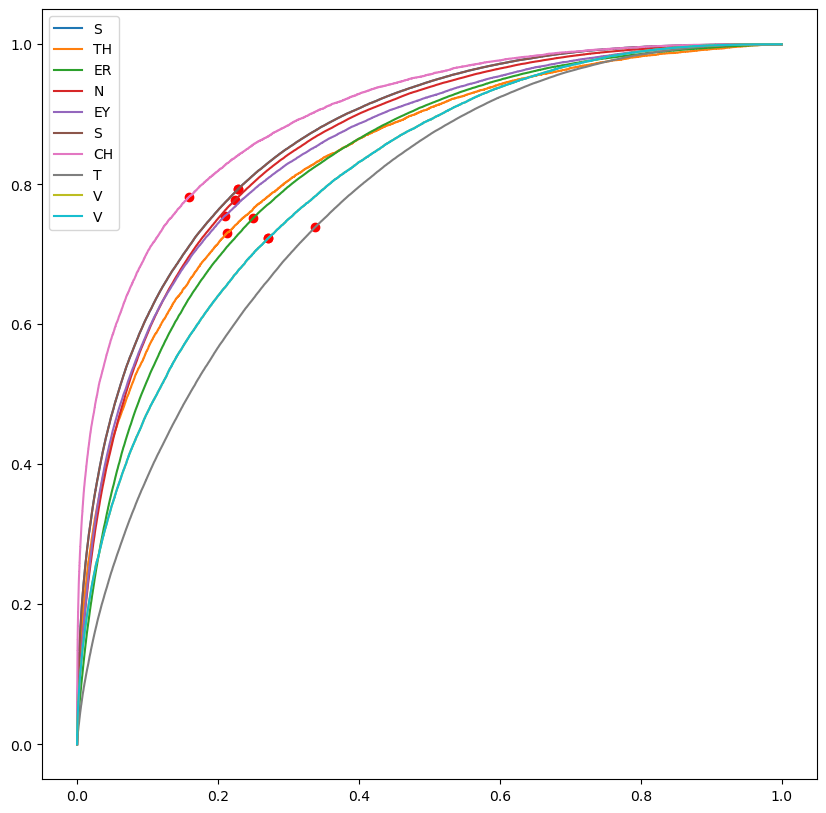

In [13]:
f, ax = plt.subplots(figsize=(10, 10))
for idx in np.random.choice(len(fpr), 10):
    ax.plot(fpr[idx], tpr[idx], label=tokenizer.convert_ids_to_tokens([idx])[0])
    opt_threshold_idx = np.argmax(tpr[idx] - fpr[idx])
    ax.scatter(fpr[idx][opt_threshold_idx], tpr[idx][opt_threshold_idx], c="r")
ax.legend()

In [14]:
eval_predictions = trainer.predict(corpus["test"])

In [15]:
def add_predictions(batch, idxs):
    eval_output = eval_predictions.predictions
    eval_output = eval_output[0] if isinstance(eval_output, tuple) else eval_output
    logits = eval_output[idxs]
    preds = (logits > optimal_thresholds.numpy()).astype(int)

    batch["score"] = logits
    batch["distance_from_decision_threshold"] = logits - optimal_thresholds.numpy()
    batch["predicted"] = preds

    return batch

eval_result = corpus["test"].map(add_predictions, batched=True, batch_size=8, with_indices=True)

def compute_accuracy(item, idx):
    label_mask, labels = eval_predictions.label_ids
    label_mask = label_mask[idx] == 1
    labels = labels[idx]

    item["real_frames"] = label_mask.sum()
    item["correct"] = (np.array(item["predicted"])[label_mask] == labels[label_mask])
    item["fp"] = (np.array(item["predicted"])[label_mask] == 1) & (labels[label_mask] == 0)
    item["fn"] = (np.array(item["predicted"])[label_mask] == 0) & (labels[label_mask] == 1)
    item["tp"] = (np.array(item["predicted"])[label_mask] == 1) & (labels[label_mask] == 1)
    item["tn"] = (np.array(item["predicted"])[label_mask] == 0) & (labels[label_mask] == 0)
    item["accuracy"] = item["correct"].mean()
    return item

eval_result = eval_result.map(compute_accuracy, batched=False, with_indices=True)

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

In [16]:
viz_columns = [None] * tokenizer.vocab_size
for token, idx in tokenizer.get_vocab().items():
    if idx < tokenizer.vocab_size:
        viz_columns[idx] = token

In [17]:
def plot_timit_items(idxs, phone_plot_key="phonemic_detail"):
    f, axs = plt.subplots(len(idxs), figsize=(20, 8 * len(idxs)))

    for idx, ax in zip(idxs, axs.ravel()):
        item = eval_result[idx]

        # compute compression ratio between input and output
        num_item_frames = item["real_frames"]
        num_input_frames = len(item["input_values"])
        compression_ratio = num_item_frames / num_input_frames

        word_detail = item["word_detail"]
        word_starts = set()
        for start, stop, word in zip(word_detail["start"], word_detail["stop"], word_detail["utterance"]):
            start = start * compression_ratio
            stop = stop * compression_ratio
            word_starts.add(start)

            ax.axhline(start, color="white", linestyle="--")
            # show phone centered over its span
            ax.text(-2, (start + stop) / 2, word, ha="right", va="center", fontsize=14)

        for i, (start, stop, phon) in enumerate(zip(item[phone_plot_key]["start"], item[phone_plot_key]["stop"], item[phone_plot_key]["utterance"])):
            start = start * compression_ratio
            stop = stop * compression_ratio

            if start not in word_starts:
                ax.axhline(start, color="white", linestyle="--", alpha=0.5)
            
            # show phone centered over its span
            ax.text(0, (start + stop) / 2, phon, ha="right", va="center", fontsize=12)

        yield ax, item

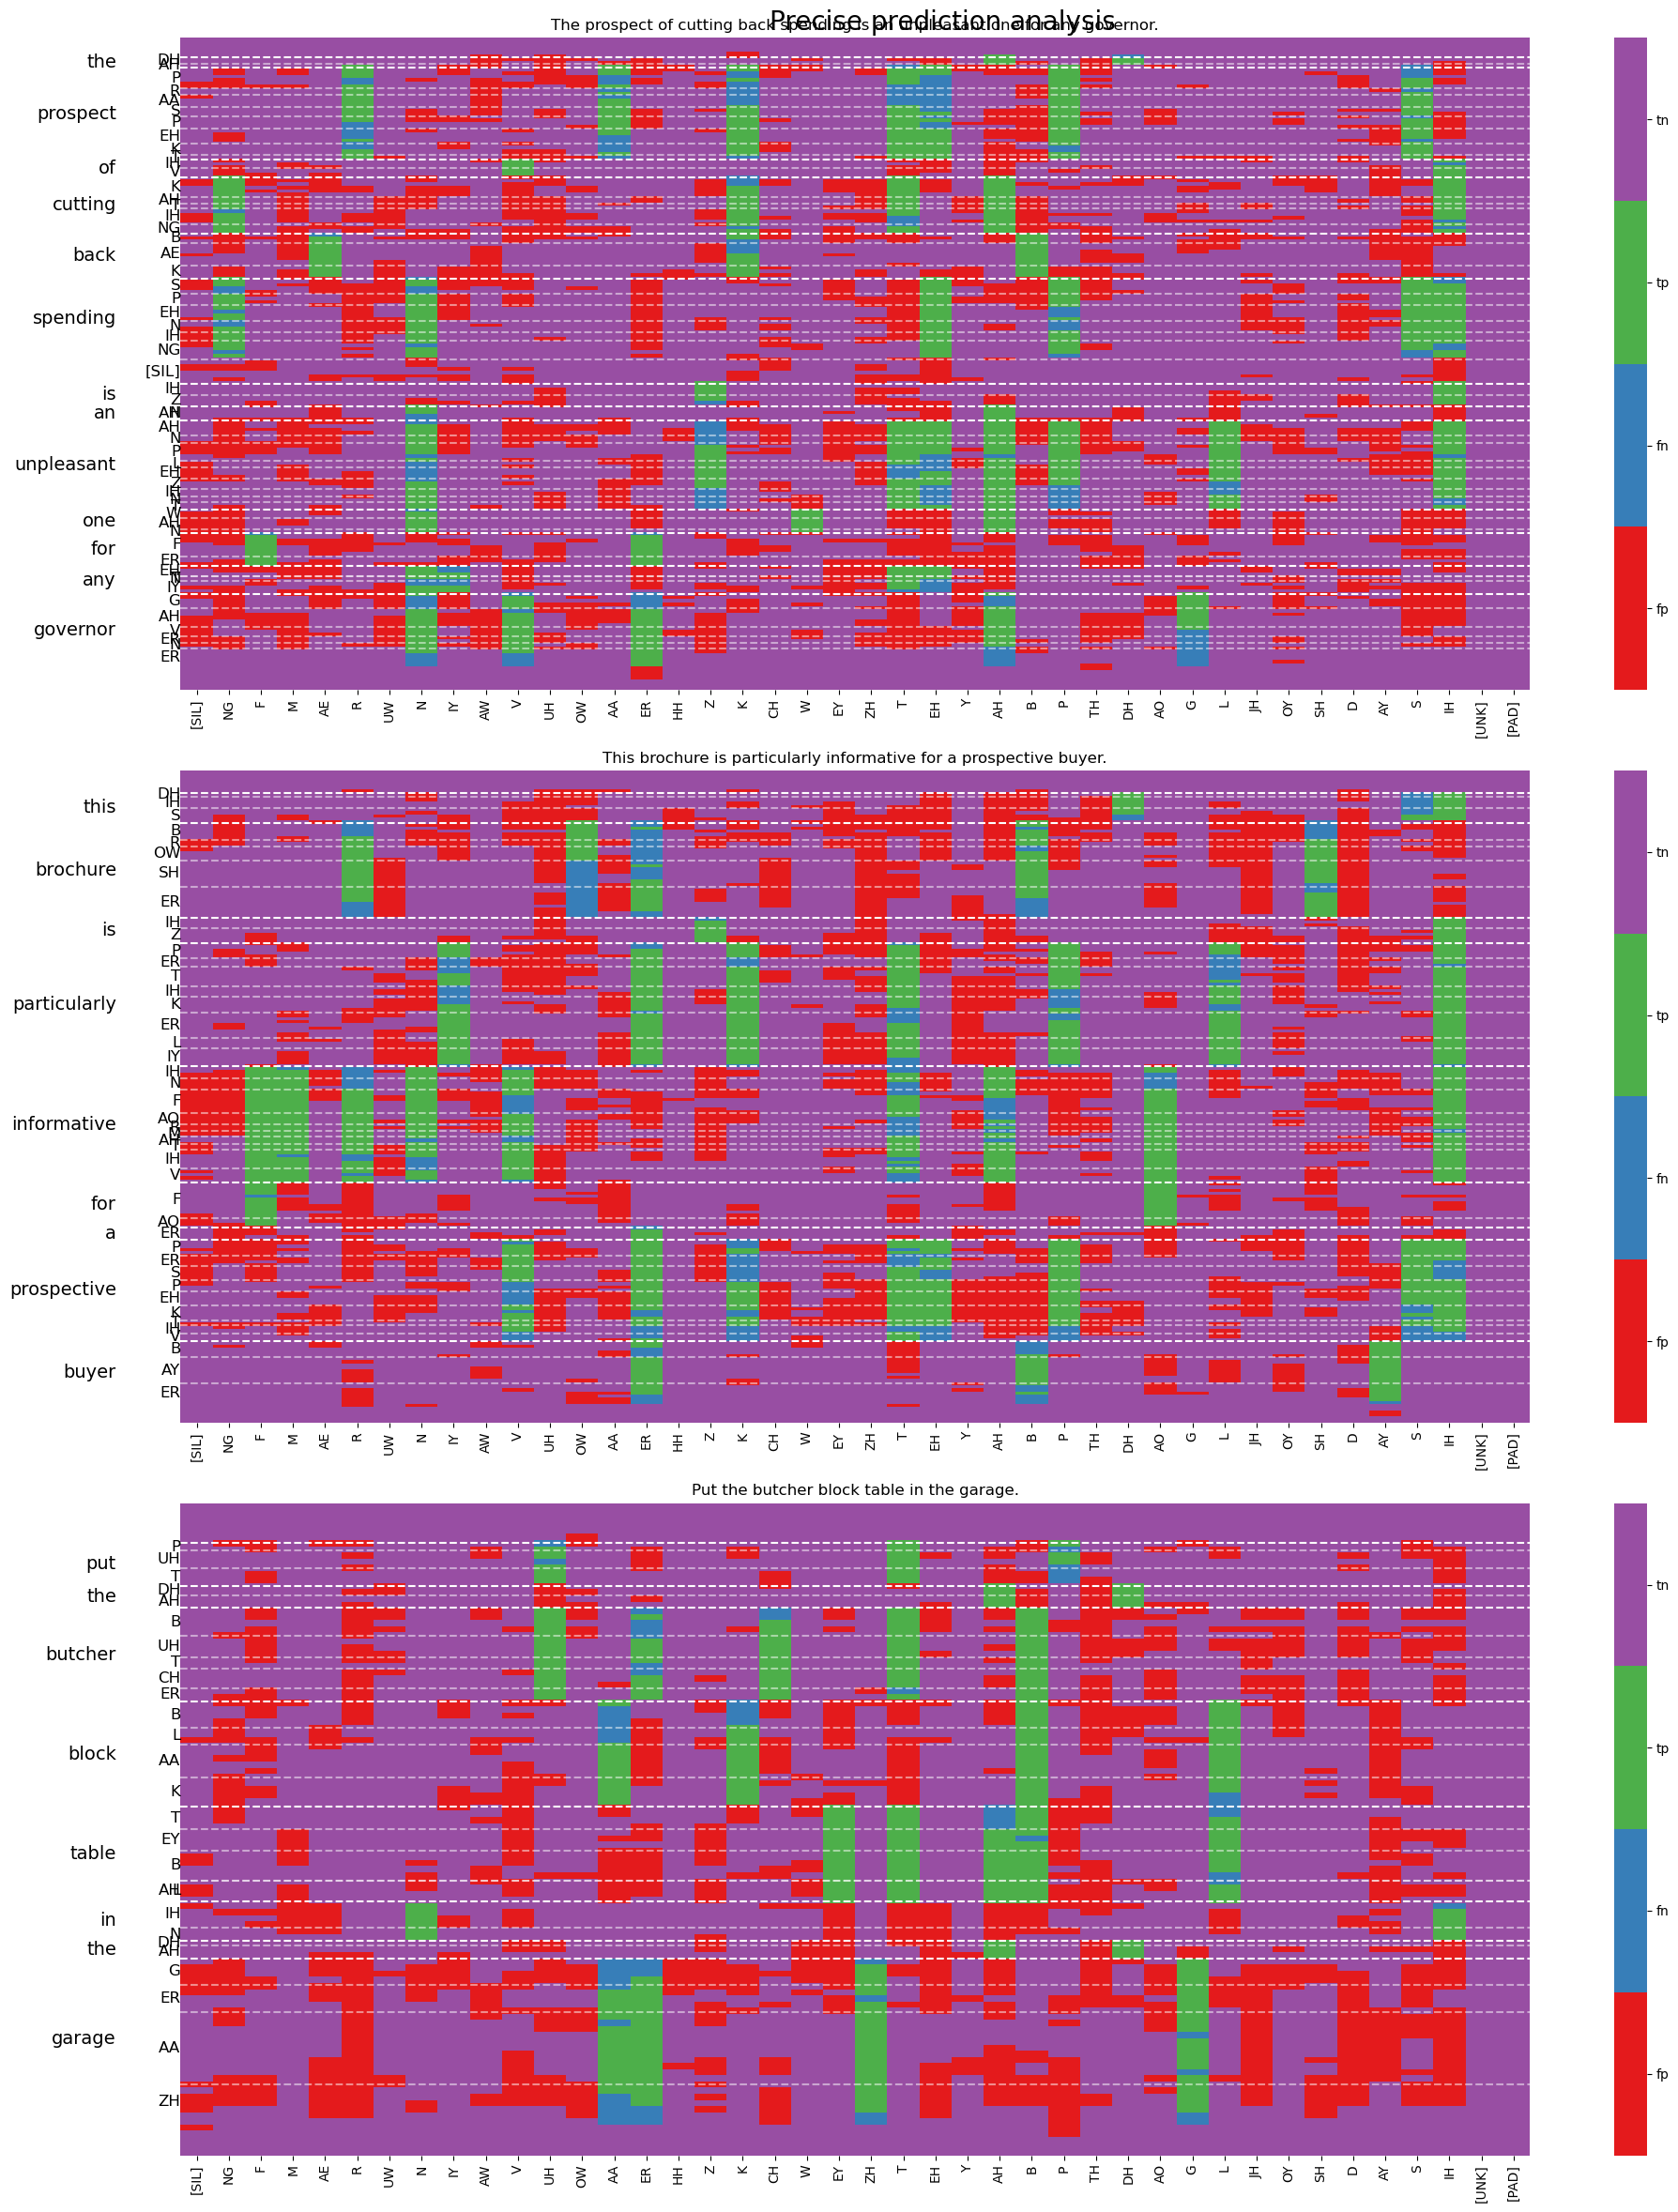

In [18]:
# viz phoneme predictions
n_to_plot = 3
plot_idxs = np.random.choice(len(eval_result), n_to_plot, replace=False).tolist()

for ax, item in plot_timit_items(plot_idxs):
    data = np.zeros_like(item["correct"]).astype(int)
    data[np.array(item["fp"])] = 1
    data[np.array(item["fn"])] = 2
    data[np.array(item["tp"])] = 3
    data[np.array(item["tn"])] = 4
    color_labels = ["fp", "fn", "tp", "tn"]

    # result = pd.DataFrame(np.array(item["correct"])[:num_item_frames], columns=viz_columns)
    result = pd.DataFrame(data[:item["real_frames"]], columns=viz_columns)
    sns.heatmap(result, ax=ax, cmap=sns.color_palette("Set1", 4))
    ax.set_title(item["text"])
    ax.set_yticks([])
    colorbar = ax.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / 4 * (0.5 + i) for i in range(4)])
    colorbar.set_ticklabels(color_labels)

ax.figure.suptitle("Precise prediction analysis", fontsize=20)
ax.figure.tight_layout()

Text(0.5, 0.98, 'Raw predictions')

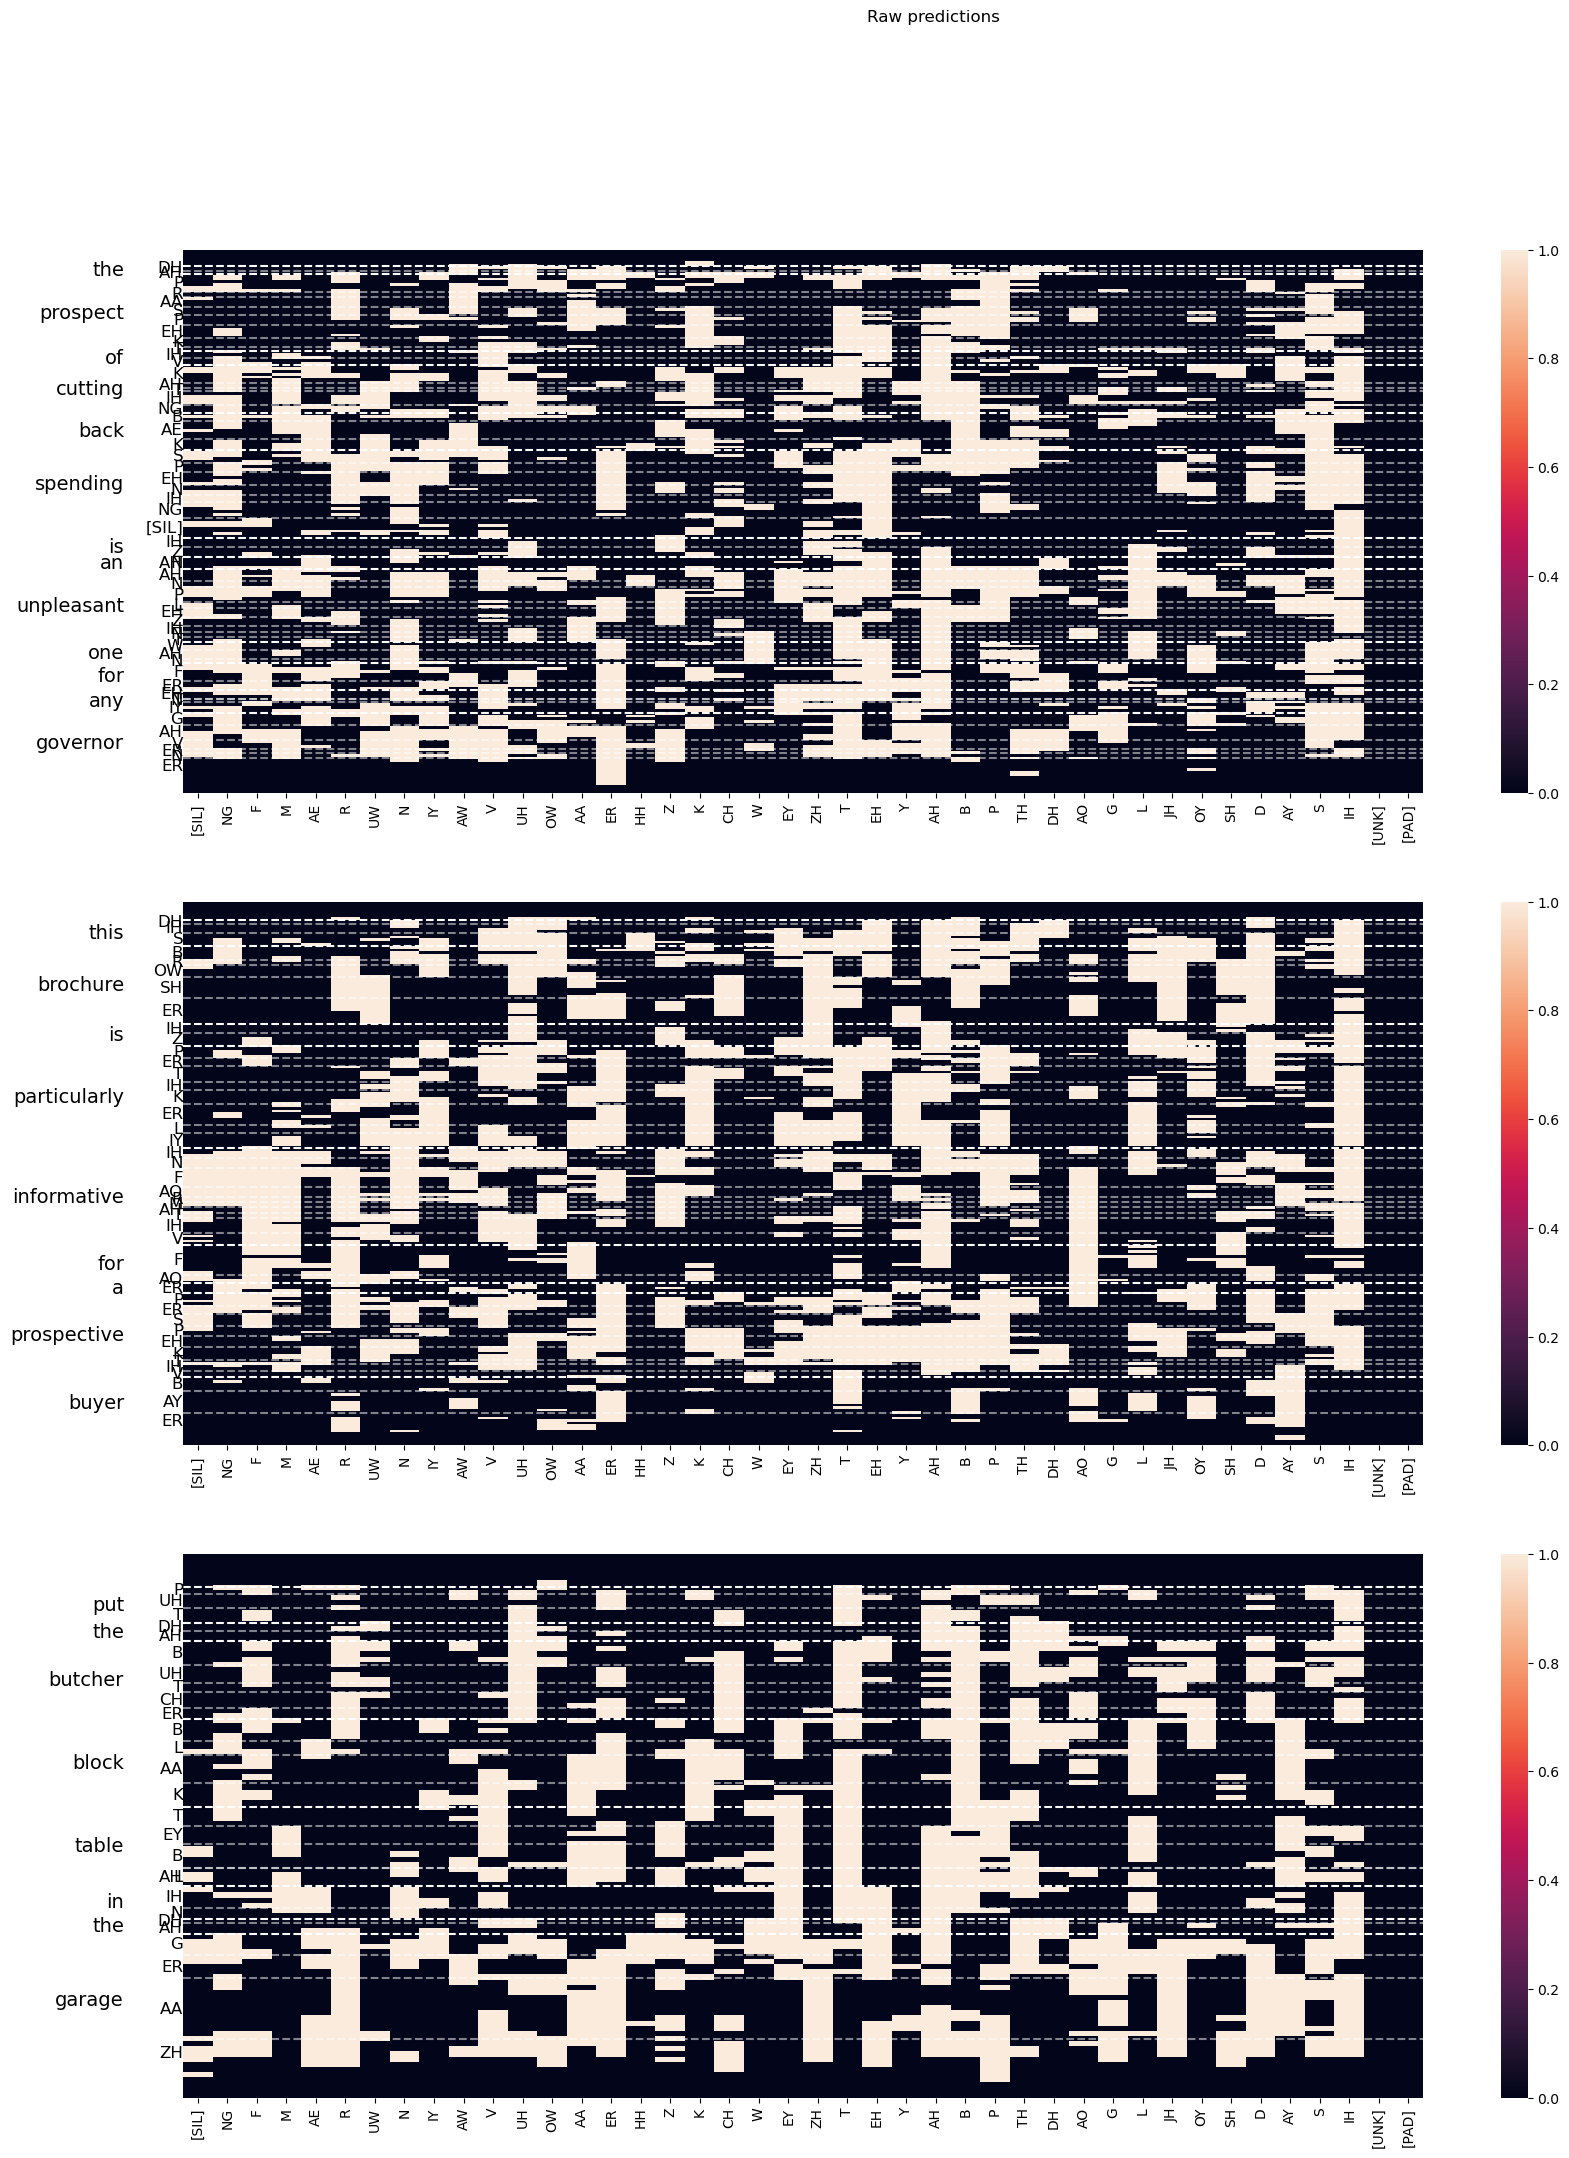

In [19]:
# viz raw predictions
for ax, item in plot_timit_items(plot_idxs):
    result = pd.DataFrame(item["predicted"][:item["real_frames"]],
                          columns=viz_columns)
    sns.heatmap(result, ax=ax)
    ax.set_yticks([])

ax.figure.suptitle("Raw predictions")

Text(0.5, 0.98, 'Ground truth')

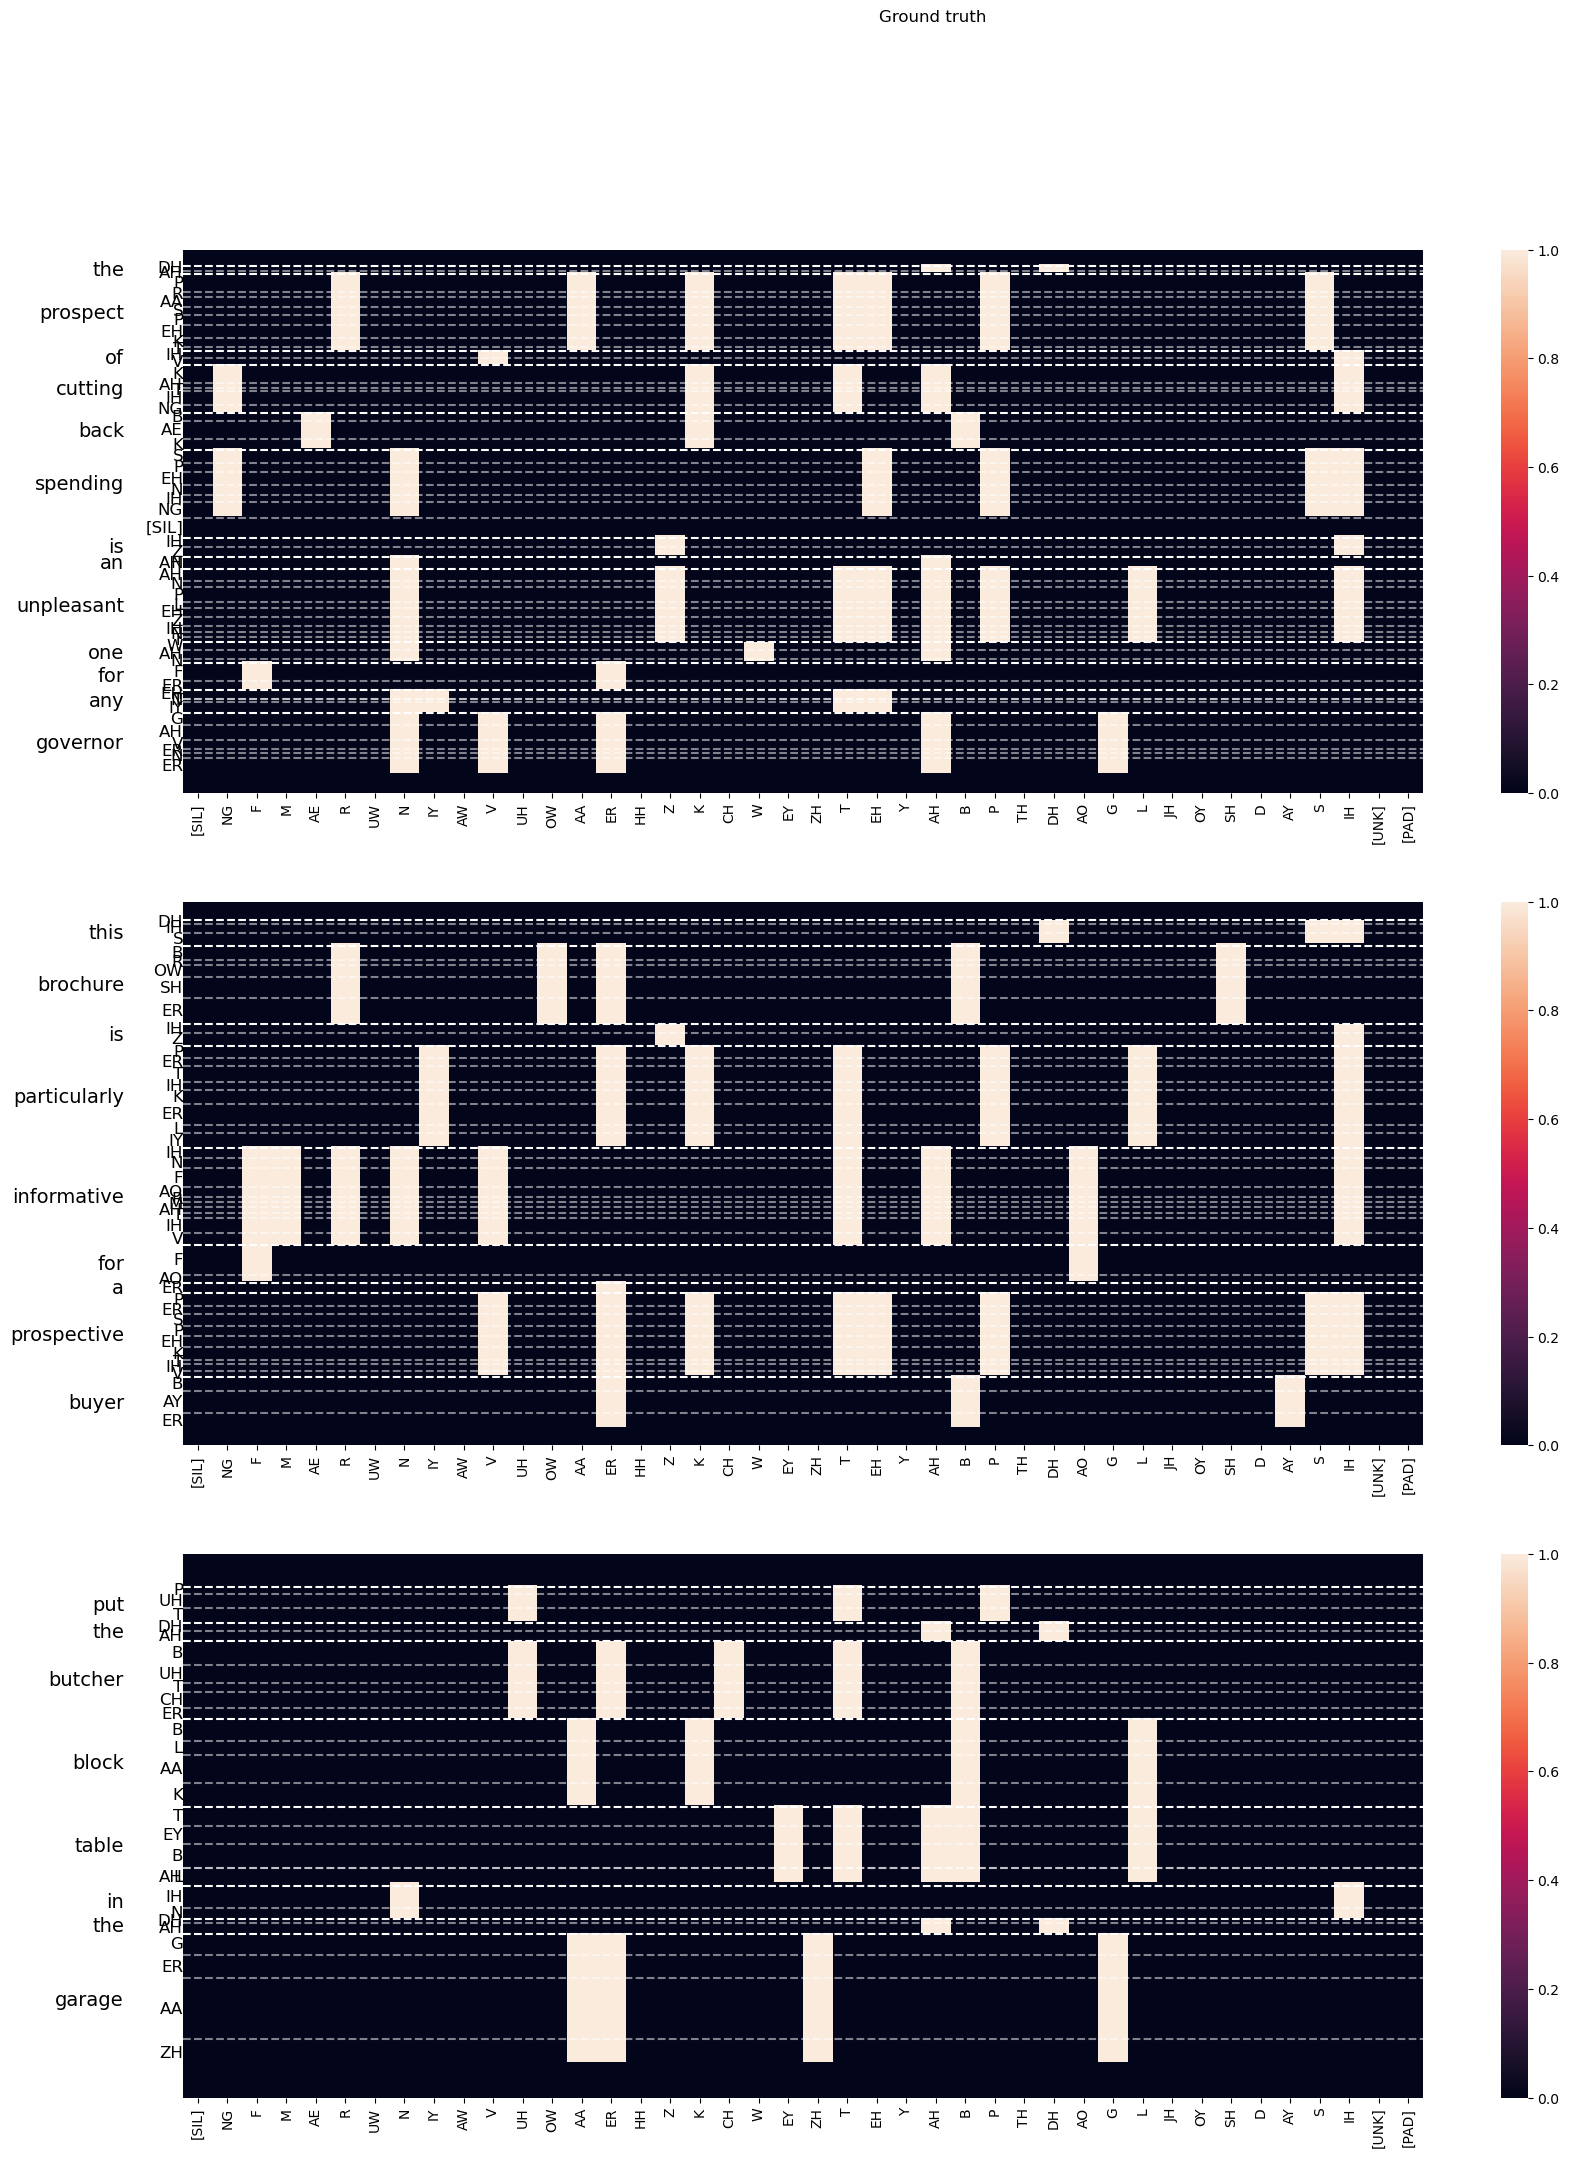

In [20]:
# viz labels
for ax, item in plot_timit_items(plot_idxs):
    compression_ratio = item["real_frames"] / len(item["input_values"])
    label_mat = np.zeros_like(item["predicted"])
    for onset, offset, idx in item["phone_targets"]:
        onset = int(onset * compression_ratio)
        offset = int(offset * compression_ratio)
        label_mat[onset:offset, idx] = 1

    result = pd.DataFrame(label_mat[:item["real_frames"]], columns=viz_columns)
    sns.heatmap(result, ax=ax)
    ax.set_yticks([])

ax.figure.suptitle("Ground truth")